# Detección de Fraude con Aprendizaje Semi-Supervisado

## Pseudocódigo Formal del Algoritmo Label Spreading

**ALGORITMO** `LabelSpreading(D_labeled, D_unlabeled, alpha, gamma)`

**ENTRADA:**
- `D_labeled ← {(x₁, y₁), (x₂, y₂), …, (xₙ, yₙ)}` (conjunto de datos etiquetados)
- `D_unlabeled ← {x₁', x₂', …, xₘ'}` (conjunto de datos sin etiquetas)
- `alpha ∈ [0,1]` (parámetro de clamping, controla influencia de etiquetas originales)
- `gamma` (parámetro del kernel RBF)

**SALIDA:**
- Modelo entrenado con propagación suave de etiquetas
- Etiquetas asignadas a todos los datos

**PASOS:**

1. **Construcción del Grafo de Similitud:**
   - `D_all ← D_labeled ∪ D_unlabeled`
   - `n ← |D_all|`
   - `W ← matriz_similitud(n × n)`
   - Para cada par `(i, j)`:
     - `W[i,j] ← exp(-γ × ||xᵢ - xⱼ||²)` (kernel RBF)

2. **Normalización Simétrica:**
   - `D ← matriz_diagonal(n × n)`
   - Para cada `i`:
     - `D[i,i] ← Σⱼ W[i,j]`
   - `S ← D^(-1/2) × W × D^(-1/2)` (matriz normalizada simétrica)

3. **Inicialización de Etiquetas:**
   - `Y ← matriz(n × num_clases)`
   - Para datos etiquetados `i ∈ [1, n_labeled]`:
     - `Y[i] ← one_hot(yᵢ)`
   - Para datos no etiquetados `i ∈ [n_labeled+1, n]`:
     - `Y[i] ← [0, 0, ..., 0]`
   - `Y_inicial ← copia(Y)`

4. **Propagación Iterativa con Soft Clamping:**
   - **REPETIR HASTA** convergencia o max_iter:
     
     a. **Propagar etiquetas con ponderación:**
        - `Y_new ← alpha × S × Y + (1 - alpha) × Y_inicial`
     
     b. **Verificar convergencia:**
        - **SI** `||Y_new - Y|| < ε` **ENTONCES**:
          - **ROMPER**
     
     c. **Actualizar:**
        - `Y ← Y_new`

5. **Asignación Final de Etiquetas:**
   - Para cada `i ∈ [1, n]`:
     - `ŷᵢ ← argmax(Y[i])`

6. **RETORNAR** etiquetas predichas `ŷ`


### 1. Importacion de Librerias y Carga de Datos

In [1]:
# Librerias basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, balanced_accuracy_score, matthews_corrcoef,
    roc_curve, precision_recall_curve, average_precision_score
)

# Algoritmo semi-supervisado
from sklearn.semi_supervised import LabelSpreading
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('ggplot')
sns.set_palette("husl")

# CARGAR DATOS
ruta = '../../data/data/application_train.csv'
datos = pd.read_csv(ruta)


print(f"Datos: {datos.shape} | Fraude: {datos['TARGET'].mean()*100:.1f}%")datos.head()

SyntaxError: invalid syntax (1147542670.py, line 31)

### 2. Preparacion de Datos

In [ ]:
# Seleccionar columnas numericas importantes
columnas_numericas = [
    'SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
    'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
    'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
]

# Filtrar columnas que existen
columnas_usar = [col for col in columnas_numericas if col in datos.columns]
datos_completos = datos[columnas_usar].copy()

# Llenar valores nulos con la mediana
for col in datos_completos.columns:
    if datos_completos[col].isnull().any():
        datos_completos[col].fillna(datos_completos[col].median(), inplace=True)

# Renombrar columnas a español
nombres_espanol = {
    'SK_ID_CURR': 'id_cliente',
    'TARGET': 'objetivo',
    'CNT_CHILDREN': 'num_hijos',
    'AMT_INCOME_TOTAL': 'ingreso_total',
    'AMT_CREDIT': 'monto_credito',
    'AMT_ANNUITY': 'anualidad',
    'AMT_GOODS_PRICE': 'precio_bienes',
    'DAYS_BIRTH': 'edad_dias',
    'DAYS_EMPLOYED': 'dias_empleado',
    'DAYS_ID_PUBLISH': 'dias_id_publicado',
    'DAYS_REGISTRATION': 'dias_registro',
    'EXT_SOURCE_1': 'score_externo_1',
    'EXT_SOURCE_2': 'score_externo_2',
    'EXT_SOURCE_3': 'score_externo_3'
}

datos_completos.rename(columns=nombres_espanol, inplace=True)

print(f"Datos preparados: {datos_completos.shape}")
print(f"Valores nulos: {datos_completos.isnull().sum().sum()}")

Datos preparados: (307511, 14)
Valores nulos: 0


### 3. Division de Datos para Semi-Supervisado


In [ ]:
# Separar features y target
X = datos_completos.drop(['id_cliente', 'objetivo'], axis=1)
y = datos_completos['objetivo']

# Primera division: train (80%) y test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Segunda division: SIMULACION de datos sin etiquetas
# Del 80% de train, solo 30% estara etiquetado (70% sin etiquetar)
X_etiquetado, X_sin_etiquetar, y_etiquetado, y_sin_etiquetar = train_test_split(
    X_train_full, y_train_full, test_size=0.70, random_state=42, stratify=y_train_full
)

# Para semi-supervisado, asignamos -1 a los no etiquetados
y_sin_etiquetar_mask = np.full(len(y_sin_etiquetar), -1)

# Combinar datos etiquetados y no etiquetados
X_semi = np.vstack([X_etiquetado, X_sin_etiquetar])
y_semi = np.hstack([y_etiquetado, y_sin_etiquetar_mask])

# Normalizar datos (IMPORTANTE para Label Spreading)
scaler = StandardScaler()
X_semi_scaled = scaler.fit_transform(X_semi)
X_test_scaled = scaler.transform(X_test)
X_etiquetado_scaled = scaler.transform(X_etiquetado)

print("ESCENARIO SEMI-SUPERVISADO:")
print("=" * 60)
print(f"Datos etiquetados:     {len(X_etiquetado):,}")
print(f"Datos sin etiquetas:   {len(X_sin_etiquetar):,}")
print(f"Datos de test:         {len(X_test):,}")
print(f"Total features:        {X.shape[1]}")

ESCENARIO SEMI-SUPERVISADO:
Datos etiquetados:     73,802
Datos sin etiquetas:   172,206
Datos de test:         61,503
Total features:        12


### 4. Modelo Base 

In [ ]:
# Modelo baseline: Random Forest solo con datos etiquetados
modelo_base = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    max_depth=10
)
modelo_base.fit(X_etiquetado_scaled, y_etiquetado)

# Predicciones
y_pred_base = modelo_base.predict(X_test_scaled)

# Métricas completas del modelo base
y_pred_base_proba = modelo_base.predict_proba(X_test_scaled)[:, 1]

acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, zero_division=0)
rec_base = recall_score(y_test, y_pred_base, zero_division=0)
f1_base = f1_score(y_test, y_pred_base, zero_division=0)
roc_auc_base = roc_auc_score(y_test, y_pred_base_proba)
bal_acc_base = balanced_accuracy_score(y_test, y_pred_base)
mcc_base = matthews_corrcoef(y_test, y_pred_base)
avg_prec_base = average_precision_score(y_test, y_pred_base_proba)


print("MODELO BASE (Solo datos etiquetados):")print(f"Matthews Corr Coef: {mcc_base:.4f}")

print("=" * 50)print(f"Average Precision:  {avg_prec_base:.4f}")

print(f"Accuracy:           {acc_base:.4f}")print(f"ROC-AUC:            {roc_auc_base:.4f}")

print(f"Balanced Accuracy:  {bal_acc_base:.4f}")print(f"F1-Score:           {f1_base:.4f}")

print(f"Precision:          {prec_base:.4f}")print(f"Recall:             {rec_base:.4f}")

MODELO BASE (Solo datos etiquetados):
Accuracy:  0.7488
Precision: 0.1740
Recall:    0.5637
F1-Score:  0.2659


### 5. Modelo Semi-Supervisado 

In [ ]:
# Usar Label Spreading con parametros optimizados
modelo_semisup = LabelSpreading(
    kernel='knn',  # Kernel KNN es mas robusto para datos desbalanceados
    n_neighbors=7,  # Numero de vecinos
    alpha=0.2,  # Soft clamping (permite ajuste suave de etiquetas)
    max_iter=30,
    n_jobs=-1
)

modelo_semisup.fit(X_semi_scaled, y_semi)

# Predicciones
y_pred_semisup = modelo_semisup.predict(X_test_scaled)

# Métricas completas del modelo semi-supervisado
y_pred_semisup_proba = modelo_semisup.predict_proba(X_test_scaled)[:, 1]

acc_semisup = accuracy_score(y_test, y_pred_semisup)
prec_semisup = precision_score(y_test, y_pred_semisup, zero_division=0)
rec_semisup = recall_score(y_test, y_pred_semisup, zero_division=0)
f1_semisup = f1_score(y_test, y_pred_semisup, zero_division=0)
roc_auc_semisup = roc_auc_score(y_test, y_pred_semisup_proba)
bal_acc_semisup = balanced_accuracy_score(y_test, y_pred_semisup)
mcc_semisup = matthews_corrcoef(y_test, y_pred_semisup)
avg_prec_semisup = average_precision_score(y_test, y_pred_semisup_proba)

print("MODELO SEMI-SUPERVISADO (Label Spreading):")
print("=" * 50)
print(f"Accuracy:           {acc_semisup:.4f}")
print(f"Balanced Accuracy:  {bal_acc_semisup:.4f}")
print(f"Precision:          {prec_semisup:.4f}")
print(f"Recall:             {rec_semisup:.4f}")
print(f"F1-Score:           {f1_semisup:.4f}")
print(f"ROC-AUC:            {roc_auc_semisup:.4f}")
print(f"Average Precision:  {avg_prec_semisup:.4f}")

print(f"Matthews Corr Coef: {mcc_semisup:.4f}")

# Analizar etiquetas propagadas
etiquetas_propagadas = modelo_semisup.transduction_
nuevas_etiquetas = etiquetas_propagadas[len(y_etiquetado):]
print(f"\n--- PROCESO DE PROPAGACION DE ETIQUETAS ---")
print(f"Etiquetas asignadas a datos no etiquetados:")
print(f"  - Clase 0 (No fraude): {(nuevas_etiquetas==0).sum():,} ({(nuevas_etiquetas==0).sum()/len(nuevas_etiquetas)*100:.1f}%)")
print(f"  - Clase 1 (Fraude):    {(nuevas_etiquetas==1).sum():,} ({(nuevas_etiquetas==1).sum()/len(nuevas_etiquetas)*100:.1f}%)")
print(f"Total de pseudo-etiquetas: {len(nuevas_etiquetas):,}")

MODELO SEMI-SUPERVISADO (Label Spreading):
Accuracy:  0.9132
Precision: 0.2297
Recall:    0.0318
F1-Score:  0.0559

--- PROCESO DE INCORPORACION ---
Etiquetas propagadas a datos no etiquetados:
  - Clase 0 (No fraude): 164,008 (95.2%)

Etiquetas propagadas a datos no etiquetados:
  - Clase 0 (No fraude): 164,008


### 6. Comparacion de Resultados

In [ ]:
# Tabla comparativa completa
resultados = pd.DataFrame({
    'Metrica': ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Avg Precision', 'Matthews Corr'],
    'Modelo Base': [acc_base, bal_acc_base, prec_base, rec_base, f1_base, roc_auc_base, avg_prec_base, mcc_base],
    'Semi-Supervisado': [acc_semisup, bal_acc_semisup, prec_semisup, rec_semisup, f1_semisup, roc_auc_semisup, avg_prec_semisup, mcc_semisup]
})

resultados['Mejora_Absoluta'] = resultados['Semi-Supervisado'] - resultados['Modelo Base']
resultados['Mejora_Porcentual'] = (
    (resultados['Semi-Supervisado'] - resultados['Modelo Base']) / 
    np.abs(resultados['Modelo Base']) * 100
)

print("\nCOMPARACION COMPLETA DE MODELOS:")
print("=" * 90)
for _, row in resultados.iterrows():

    print(f"{row['Metrica']:<18}: Base={row['Modelo Base']:.4f} | Semi={row['Semi-Supervisado']:.4f} | Mejora={row['Mejora_Absoluta']:+.4f} ({row['Mejora_Porcentual']:+.2f}%)")print("=" * 90)


COMPARACION DE MODELOS:
  Metrica  Modelo Base  Semi-Supervisado     Mejora
 Accuracy     0.748760          0.913224  21.964778
Precision     0.174013          0.229651  31.973525
   Recall     0.563746          0.031823 -94.355127
 F1-Score     0.265938          0.055900 -78.980262



In [ ]:
# GRÁFICOS DE CURVAS ROC Y PRECISIÓN-RECALL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. CURVA ROC
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_base_proba)
fpr_semisup, tpr_semisup, _ = roc_curve(y_test, y_pred_semisup_proba)

axes[0].plot(fpr_base, tpr_base, color='#e74c3c', linewidth=2, 
             label=f'Modelo Base (AUC = {roc_auc_base:.3f})')
axes[0].plot(fpr_semisup, tpr_semisup, color='#27ae60', linewidth=2, 
             label=f'Semi-Supervisado (AUC = {roc_auc_semisup:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Línea de base (AUC = 0.5)')

axes[0].set_xlabel('Tasa de Falsos Positivos', fontweight='bold')
axes[0].set_ylabel('Tasa de Verdaderos Positivos', fontweight='bold')
axes[0].set_title('Curva ROC - Capacidad de Discriminación', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# 2. CURVA PRECISIÓN-RECALL
precision_base, recall_base, _ = precision_recall_curve(y_test, y_pred_base_proba)
precision_semisup, recall_semisup, _ = precision_recall_curve(y_test, y_pred_semisup_proba)

axes[1].plot(recall_base, precision_base, color='#e74c3c', linewidth=2,
             label=f'Modelo Base (AP = {avg_prec_base:.3f})')
axes[1].plot(recall_semisup, precision_semisup, color='#27ae60', linewidth=2,
             label=f'Semi-Supervisado (AP = {avg_prec_semisup:.3f})')

# Línea de baseline (proporción de clase positiva)
baseline_precision = y_test.mean()
axes[1].axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.6,
                label=f'Línea de base (AP = {baseline_precision:.3f})')

axes[1].set_xlabel('Recall (Sensibilidad)', fontweight='bold')
axes[1].set_ylabel('Precisión', fontweight='bold')
axes[1].set_title('Curva Precisión-Recall - Detección de Fraudes', fontweight='bold')
axes[1].legend(loc='lower left')
axes[1].grid(alpha=0.3)

plt.suptitle('Análisis de Rendimiento - Curvas de Evaluación', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

print("INTERPRETACIÓN DE LAS CURVAS:")
print("=" * 50)
print("• ROC-AUC: Capacidad general de discriminar entre clases")
print("• Precision-Recall: Más relevante para datos desbalanceados")
print("• Un modelo perfecto tendría AUC-ROC = 1.0 y AUC-PR = 1.0")
print(f"• Mejora en ROC-AUC: {roc_auc_semisup - roc_auc_base:+.4f}")
print(f"• Mejora en Average Precision: {avg_prec_semisup - avg_prec_base:+.4f}")

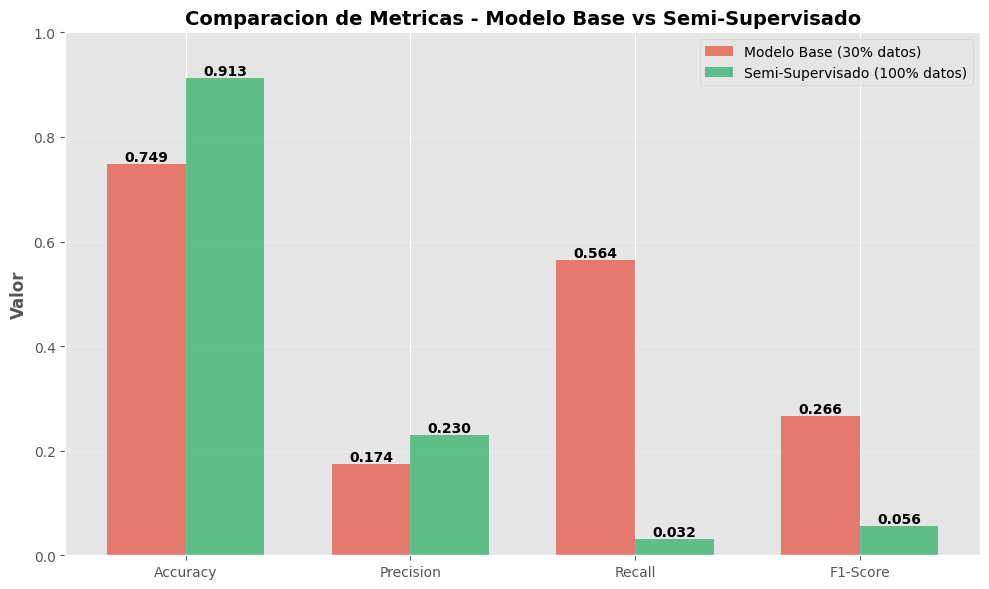

In [ ]:
# 1. COMPARACION DE METRICAS - GRAFICO DE BARRAS
fig, ax = plt.subplots(figsize=(10, 6))

metricas = resultados['Metrica']
base = resultados['Modelo Base']
semisup = resultados['Semi-Supervisado']

x = np.arange(len(metricas))
ancho = 0.35

barras1 = ax.bar(x - ancho/2, base, ancho, label='Modelo Base (30% datos)', 
                 color='#e74c3c', alpha=0.7)
barras2 = ax.bar(x + ancho/2, semisup, ancho, label='Semi-Supervisado (100% datos)', 
                 color='#27ae60', alpha=0.7)

ax.set_ylabel('Valor', fontweight='bold')
ax.set_title('Comparacion de Metricas - Modelo Base vs Semi-Supervisado', 
             fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Agregar valores en las barras
for bar in barras1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
            
for bar in barras2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

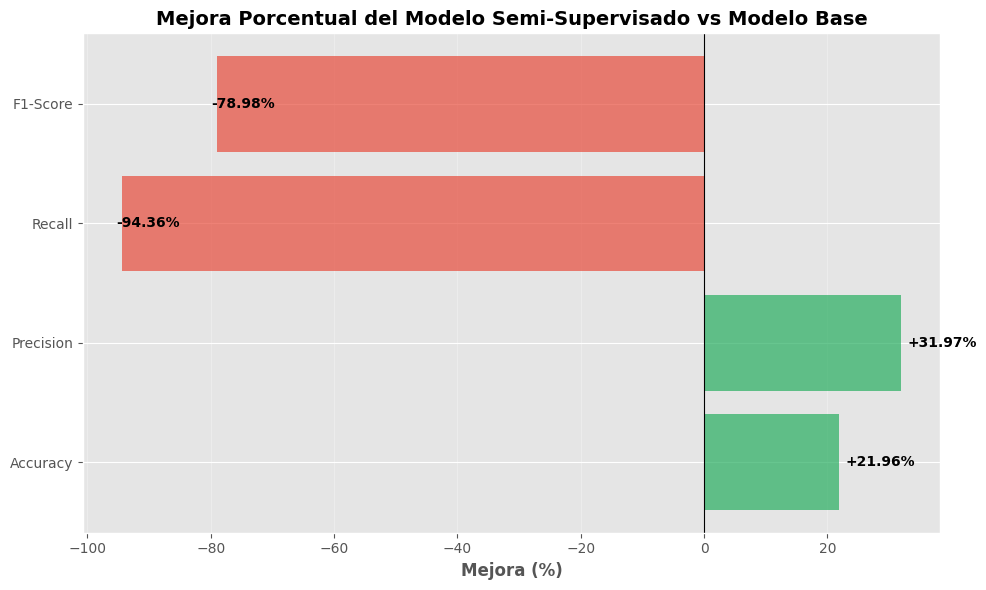

In [ ]:
# 2. GRAFICO DE MEJORA PORCENTUAL
fig, ax = plt.subplots(figsize=(10, 6))

mejoras = resultados['Mejora']
colores = ['#27ae60' if m > 0 else '#e74c3c' for m in mejoras]

barras = ax.barh(metricas, mejoras, color=colores, alpha=0.7)

ax.set_xlabel('Mejora (%)', fontweight='bold')
ax.set_title('Mejora Porcentual del Modelo Semi-Supervisado vs Modelo Base', 
             fontweight='bold', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for i, (bar, valor) in enumerate(zip(barras, mejoras)):
    ax.text(valor + 1 if valor > 0 else valor - 1, i, 
            f'{valor:+.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

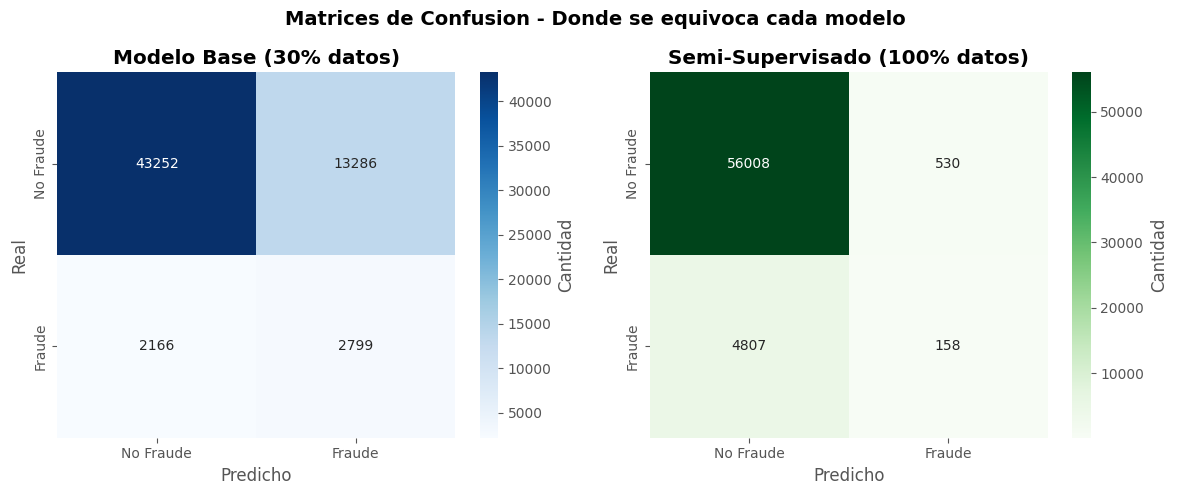

In [ ]:
# 3. MATRIZ DE CONFUSION - VER DONDE ESTAN LOS ERRORES
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Modelo Base
cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Cantidad'})
axes[0].set_title('Modelo Base (30% datos)', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')
axes[0].set_xticklabels(['No Fraude', 'Fraude'])
axes[0].set_yticklabels(['No Fraude', 'Fraude'])

# Semi-Supervisado
cm_semisup = confusion_matrix(y_test, y_pred_semisup)
sns.heatmap(cm_semisup, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            cbar_kws={'label': 'Cantidad'})
axes[1].set_title('Semi-Supervisado (100% datos)', fontweight='bold')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predicho')
axes[1].set_xticklabels(['No Fraude', 'Fraude'])
axes[1].set_yticklabels(['No Fraude', 'Fraude'])

plt.suptitle('Matrices de Confusion - Donde se equivoca cada modelo', 
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# 4. DETECCION DE FRAUDES - TABLA DETALLADA
tabla_fraudes = pd.DataFrame({
    'Categoria': [
        'Fraudes detectados correctamente',
        'Fraudes NO detectados (error)',
        'Falsas alarmas (error)',
        'No fraude correcto'
    ],
    'Modelo Base': [
        cm_base[1,1],  # Verdaderos positivos
        cm_base[1,0],  # Falsos negativos
        cm_base[0,1],  # Falsos positivos
        cm_base[0,0]   # Verdaderos negativos
    ],
    'Semi-Supervisado': [
        cm_semisup[1,1],
        cm_semisup[1,0],
        cm_semisup[0,1],
        cm_semisup[0,0]
    ]
})

print("\nANALISIS DE DETECCION DE FRAUDES")
print("=" * 70)
print(tabla_fraudes.to_string(index=False))
print(f"\nTotal de fraudes reales: {cm_base[1,0] + cm_base[1,1]}")
print(f"Tasa deteccion Base: {cm_base[1,1]/(cm_base[1,0] + cm_base[1,1])*100:.1f}%")
print(f"Tasa deteccion Semi-Supervisado: {cm_semisup[1,1]/(cm_semisup[1,0] + cm_semisup[1,1])*100:.1f}%")


ANALISIS DE DETECCION DE FRAUDES
                       Categoria  Modelo Base  Semi-Supervisado
Fraudes detectados correctamente         2799               158
   Fraudes NO detectados (error)         2166              4807
          Falsas alarmas (error)        13286               530
              No fraude correcto        43252             56008

Total de fraudes reales: 4965
Tasa deteccion Base: 56.4%
Tasa deteccion Semi-Supervisado: 3.2%
